In [9]:
%pip install nltk numpy pandas seaborn scikit-learn spacy

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [10]:
from collections import Counter
from nltk.corpus import wordnet as wn
from pandas import merge, read_csv
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, precision_recall_fscore_support
from spacy.lang.en import English

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import seaborn as sns

In [11]:
data_path = 'BUILD/'
model_path = 'MODELS/'
output_path = 'OUTPUT/'

models = [
    'feature_based',
    'distilbert',
    'legalbert',
    'roberta'
]

model_paths = [
    'feature_based',
    'distilbert_3',
    'legalbert_2',
    'roberta_3'
]

In [12]:
df = read_csv(f'{data_path}dev.csv')
for model_path, model in zip(model_paths, models):
    df = df.merge(read_csv(f'{output_path}{model_path}.csv'), on='annotation_id', suffixes=(None, f'_{model}'))
df

,doc_id,doc_index,sentence_index,annotation_id,text,meta_group,labels,labels_feature_based,labels_distilbert,labels_legalbert,labels_roberta
0,4115,222,52,40b9977a78e84f1da0fad3e939425b07,The Appellate Tribunal has referred to this de...,Tax,RATIO,ANALYSIS,FAC,ANALYSIS,FAC
1,4115,222,53,a850bcd509e542eba2b0111dac75dc91,"\n Similarly, in view of the orders of the Ass...",Tax,RATIO,ANALYSIS,ANALYSIS,ANALYSIS,ANALYSIS
2,4115,222,54,436108c301e14169977c0fd46318c186,\n 12. In the light of the aforesaid discussio...,Tax,RPC,RPC,RPC,RPC,RPC
3,4115,222,55,0cf6d5363ace43dab5493788c23f818b,No costs.,Tax,RPC,RPC,RPC,RPC,RPC
4,4115,222,56,e952098ec3e948cc8cac6eb6513d7e8f,"13. In view of dismissal of the appeals, IA No...",Tax,RPC,RPC,RPC,RPC,RPC
...,...,...,...,...,...,...,...,...,...,...,...
2894,4090,246,117,d20ea0cee1e1491498f05197f9ef19e0,\n So Section 132 of the Evidence Act sufficie...,Criminal,RATIO,ANALYSIS,ANALYSIS,ANALYSIS,ANALYSIS
2895,4090,246,118,1ec9d9a5c1a64a8bb423c5c8d6497892,"\n For the reasons aforesaid, the appeal is al...",Criminal,RPC,RPC,RPC,RPC,RPC
2896,4090,246,119,d1f14db1ebff454ba2f13fdc90dc875f,"The judgment and order dated April 27, 1987 pa...",Criminal,RPC,RPC,RPC,RPC,RPC
2897,4090,246,120,8adf1005d8c7458093a3f5599df282ca,\n R.S.S.,Criminal,NONE,NONE,RPC,RPC,NONE


In [13]:
df.labels.value_counts()

labels
ANALYSIS          930
FAC               674
PREAMBLE          389
PRE_RELIED        210
ARG_PETITIONER    195
NONE              137
RPC               127
ARG_RESPONDENT     78
RATIO              55
RLC                41
STA                38
ISSUE              23
PRE_NOT_RELIED      2
Name: count, dtype: int64

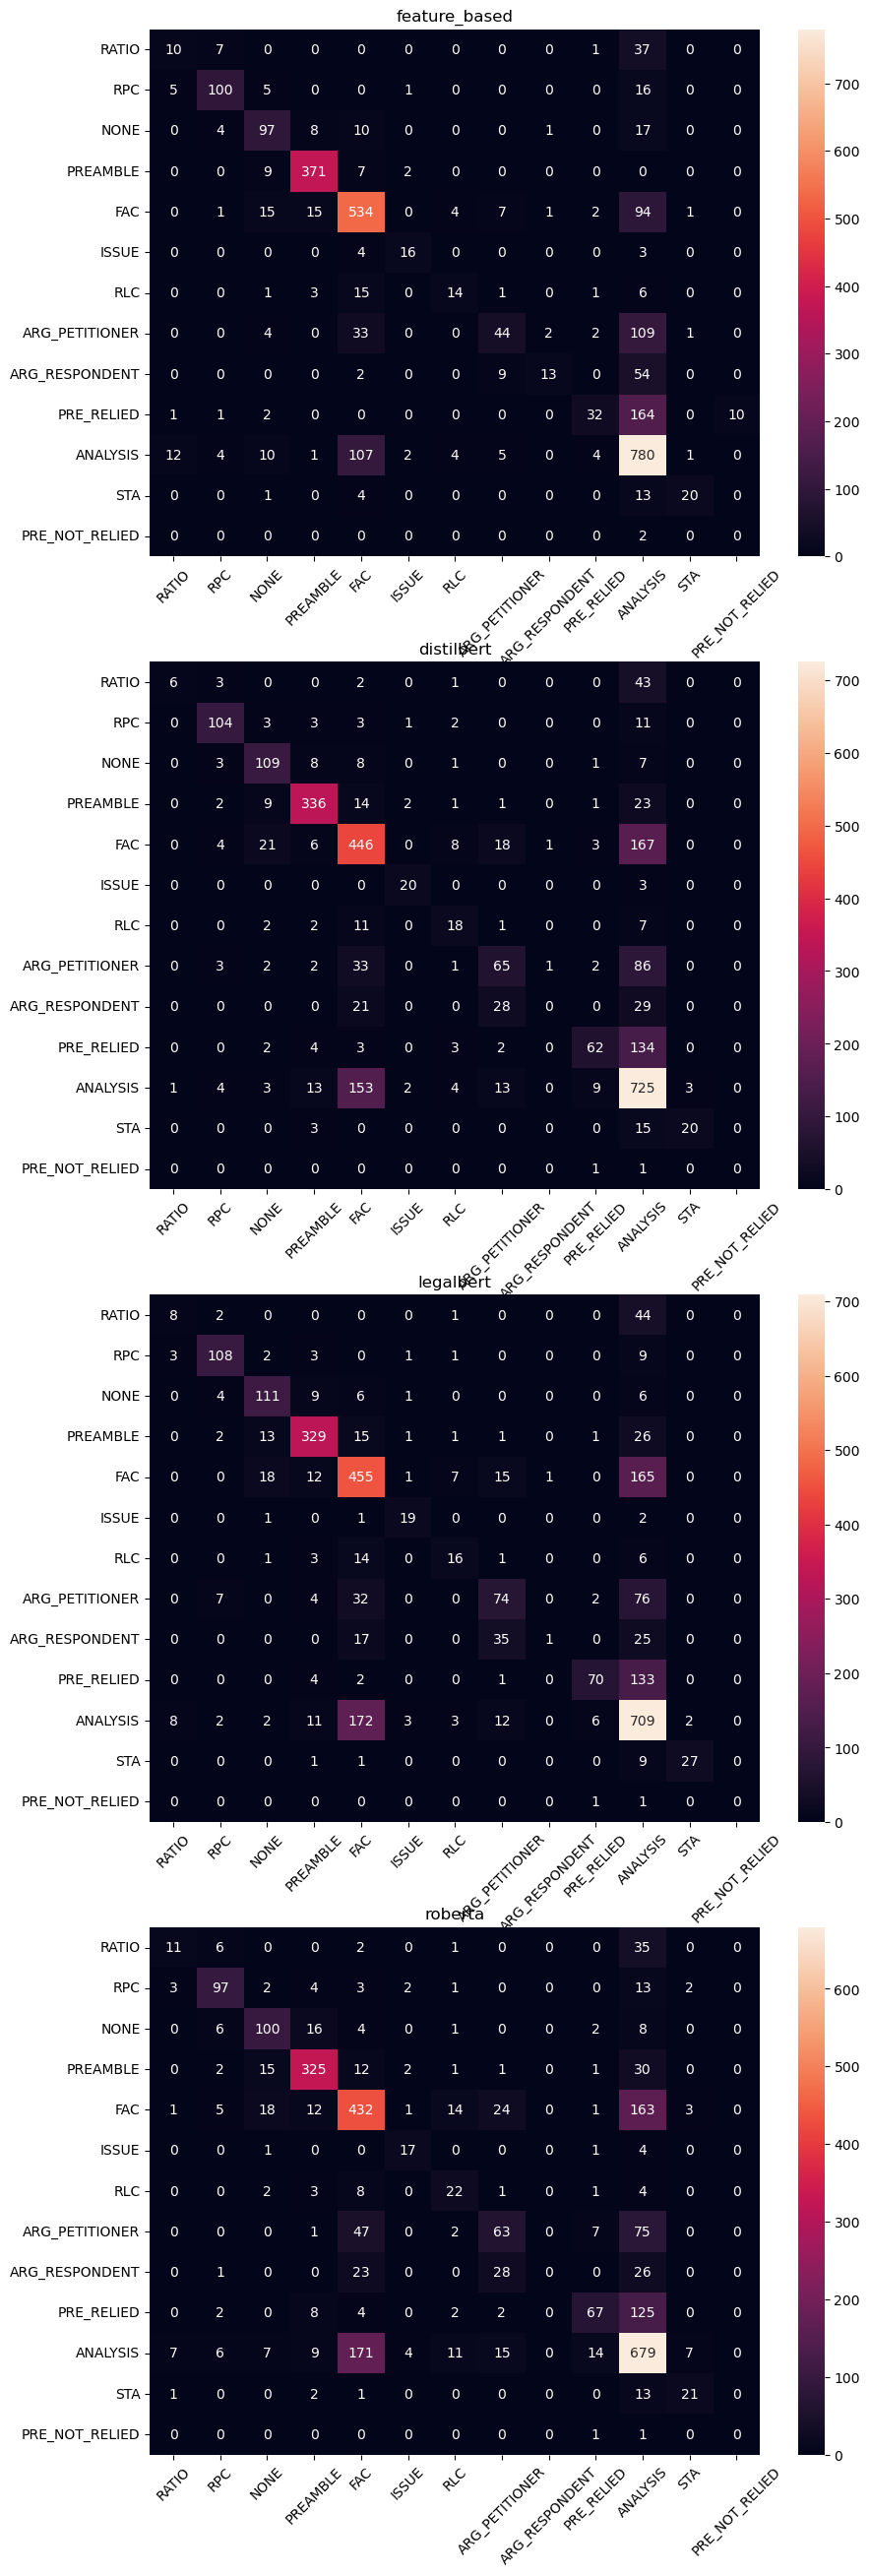

In [14]:
confusions = [confusion_matrix(df.labels, df[f'labels_{model}'], labels=df.labels.unique()) for model in models]
fig, axs = plt.subplots(len(models), figsize=(10,8*len(models)))
for ax, model, confusion in zip(axs, models, confusions):
    fig = sns.heatmap(confusion, annot=True, fmt='g', ax=ax)
    fig.set_xticklabels(df.labels.unique(), rotation=45)
    fig.set_yticklabels(df.labels.unique(), rotation=0)
    fig.set_title(model)

In [15]:
for model, confusion in zip(models, confusions):
    print(f'# {model}')
    
    # Calculate overall accuracy
    overall_accuracy = np.trace(confusion) / np.sum(confusion)
    print("Overall Accuracy:", overall_accuracy)

    # Generate a classification report
    class_report = classification_report(df.labels, df[f'labels_{model}'], zero_division=0)
    print("\nClassification Report training part:")
    print(class_report)

# feature_based
Overall Accuracy: 0.7005864091065884

Classification Report training part:
                precision    recall  f1-score   support

      ANALYSIS       0.60      0.84      0.70       930
ARG_PETITIONER       0.67      0.23      0.34       195
ARG_RESPONDENT       0.76      0.17      0.27        78
           FAC       0.75      0.79      0.77       674
         ISSUE       0.76      0.70      0.73        23
          NONE       0.67      0.71      0.69       137
      PREAMBLE       0.93      0.95      0.94       389
PRE_NOT_RELIED       0.00      0.00      0.00         2
    PRE_RELIED       0.76      0.15      0.25       210
         RATIO       0.36      0.18      0.24        55
           RLC       0.64      0.34      0.44        41
           RPC       0.85      0.79      0.82       127
           STA       0.87      0.53      0.66        38

      accuracy                           0.70      2899
     macro avg       0.66      0.49      0.53      2899
  weighted 

[Text(0, 0.5, 'feature_based'),
 Text(0, 1.5, 'distilbert'),
 Text(0, 2.5, 'legalbert'),
 Text(0, 3.5, 'roberta')]

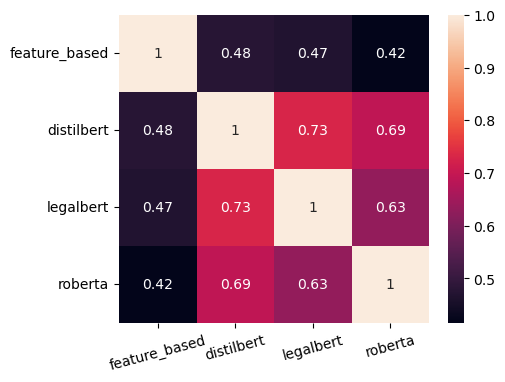

In [16]:
def label_sim(exp: str, pred_1: str, pred_2: str) -> float:
    return 1 if pred_1 == pred_2 else -1

def model_sim(model_1: str, model_2: str) -> float:
    return sum(label_sim(e.labels, getattr(e, f'labels_{model_1}'), getattr(e, f'labels_{model_2}')) for e in df.itertuples()) / len(df.index)

global_confusion = np.array([[model_sim(m1, m2) for m2 in models] for m1 in models])

plt.figure(figsize=(5, 4))
fig = sns.heatmap(global_confusion, annot=True, fmt='.2g')
fig.set_xticklabels(models, rotation=15)
fig.set_yticklabels(models, rotation=0)

[Text(0, 0.5, 'feature_based'),
 Text(0, 1.5, 'distilbert'),
 Text(0, 2.5, 'legalbert'),
 Text(0, 3.5, 'roberta')]

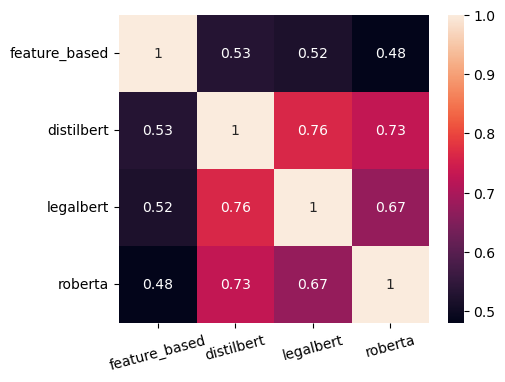

In [17]:
def label_sim(exp: str, pred_1: str, pred_2: str) -> float:
    return 1 if pred_1 == pred_2 else 0 if pred_1 != exp != pred_2 else -1

def model_sim(model_1: str, model_2: str) -> float:
    return sum(label_sim(e.labels, getattr(e, f'labels_{model_1}'), getattr(e, f'labels_{model_2}')) for e in df.itertuples()) / len(df.index)

global_confusion = np.array([[model_sim(m1, m2) for m2 in models] for m1 in models])

plt.figure(figsize=(5, 4))
fig = sns.heatmap(global_confusion, annot=True, fmt='.2g')
fig.set_xticklabels(models, rotation=15)
fig.set_yticklabels(models, rotation=0)

In [18]:
fig = sns.heatmap(100 * rel_confusions[0], annot=True, fmt='.0f')
fig.set_xticklabels(df.labels.unique(), rotation=60)
fig.set_yticklabels(df.labels.unique(), rotation=0)

NameError: name 'rel_confusions' is not defined

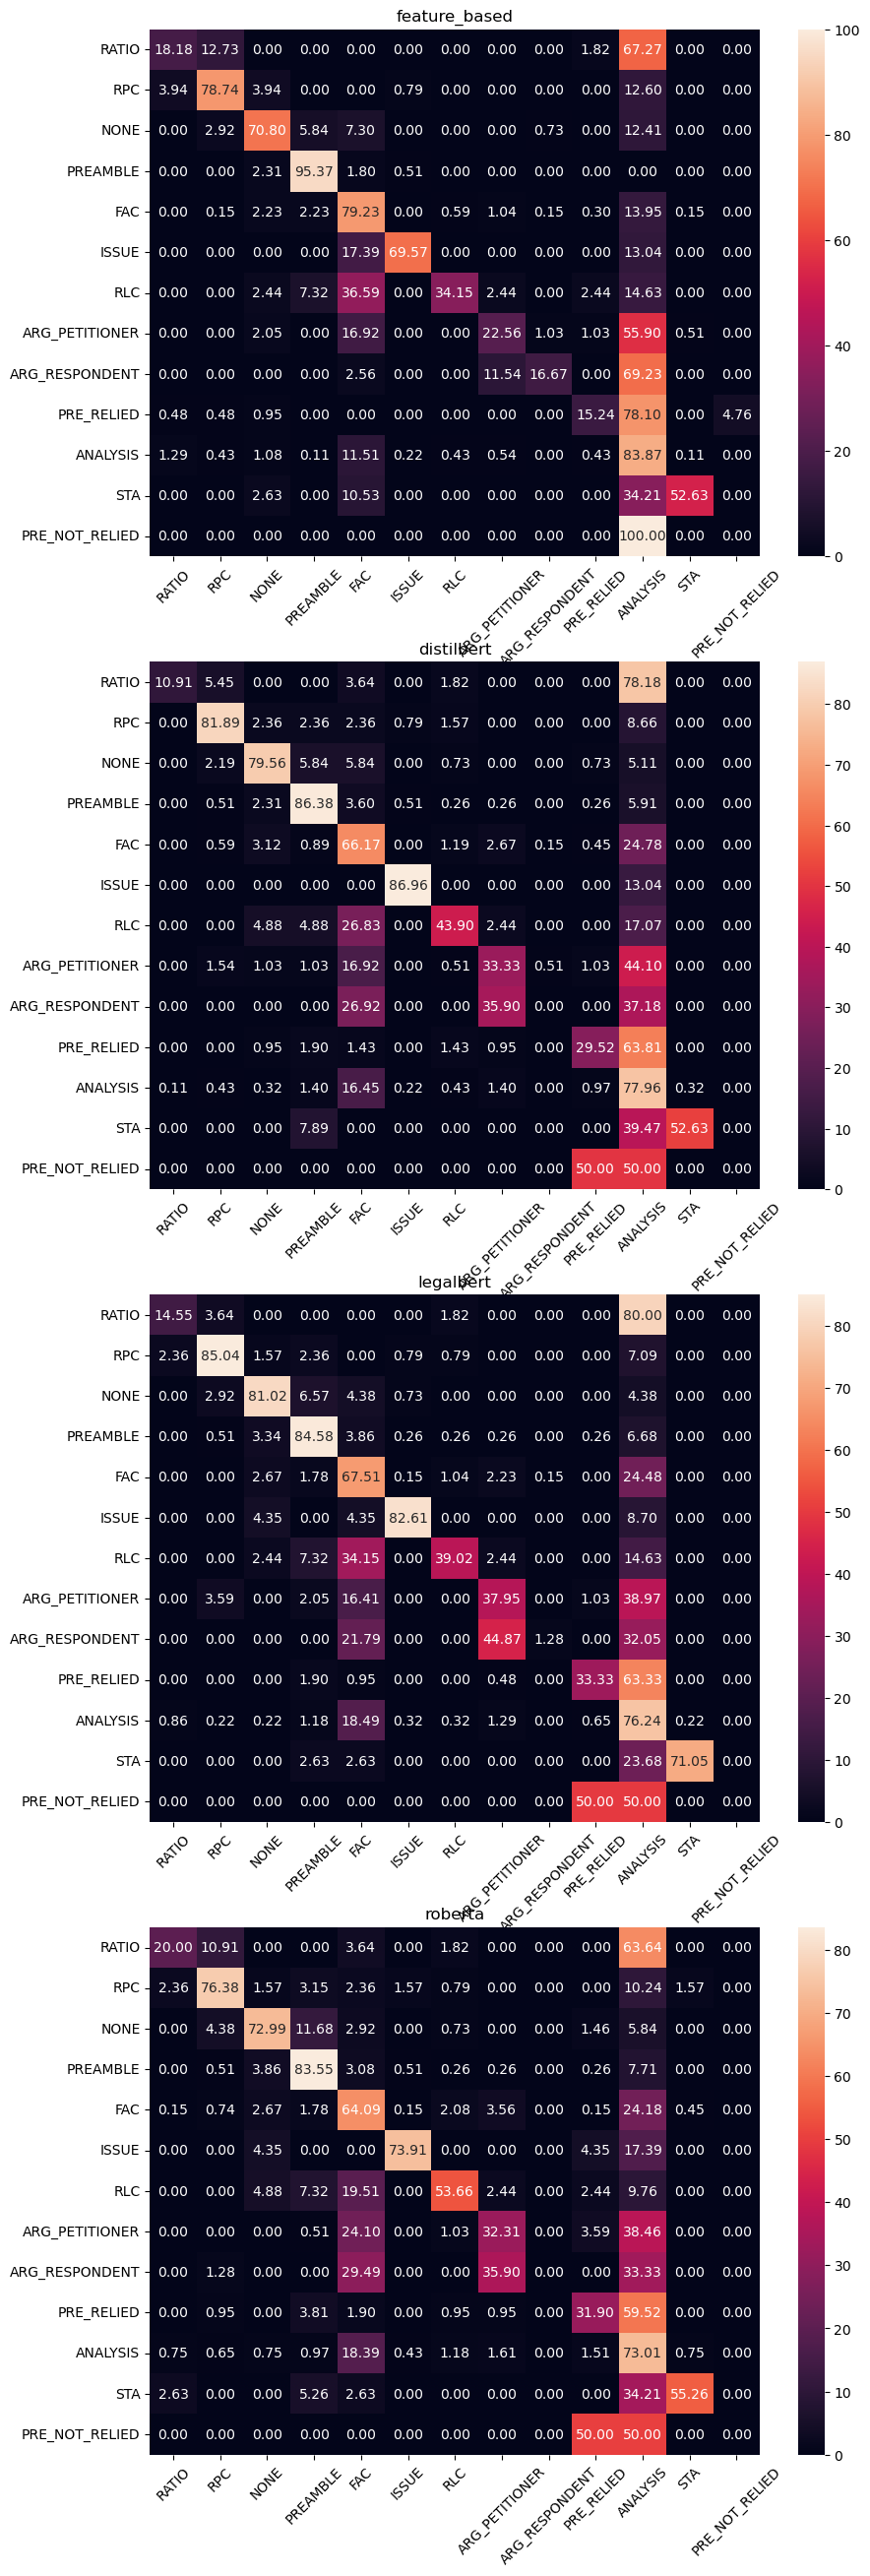

In [ ]:
rel_confusions = [confusion / confusion.sum(1)[:, None] for confusion in confusions]

fig, axs = plt.subplots(len(models), figsize=(10,8*len(models)))
for ax, model, rel_confusion in zip(axs, models, rel_confusions):
    fig = sns.heatmap(100 * rel_confusion, annot=True, fmt='.2f', ax=ax)
    fig.set_xticklabels(df.labels.unique(), rotation=45)
    fig.set_yticklabels(df.labels.unique(), rotation=0)
    fig.set_title(model)

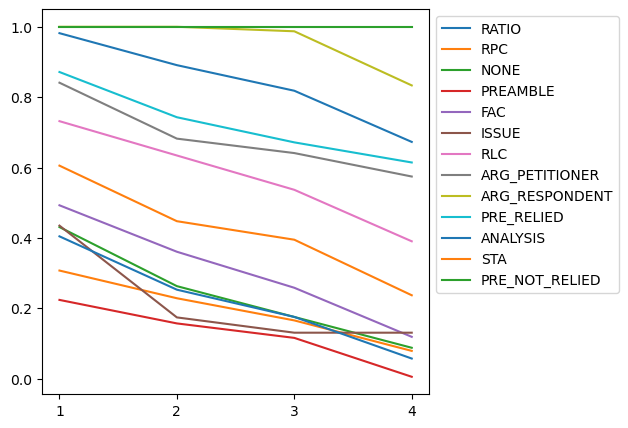

In [ ]:
def nb_err(e):
    return sum(1 if e.labels != getattr(e, f'labels_{model}') else 0 for model in models)

df['nb_err'] = [nb_err(e) for e in df.itertuples()]
class_err = [np.array([sum(1 if e.nb_err >= l else 0 for e in df[df.labels == label].itertuples()) for l in range(1, len(models) + 1)]) / len(df[df.labels == label].index) for label in df.labels.unique()]

plt.figure(figsize=(5, 5))
for label, data in zip(df.labels.unique(), class_err):
    fig = sns.lineplot(data, label=label)
    sns.move_legend(fig, 'upper left', bbox_to_anchor=(1, 1))
    fig.set_xticks(range(len(models)))
    fig.set_xticklabels(range(1, len(models) + 1))

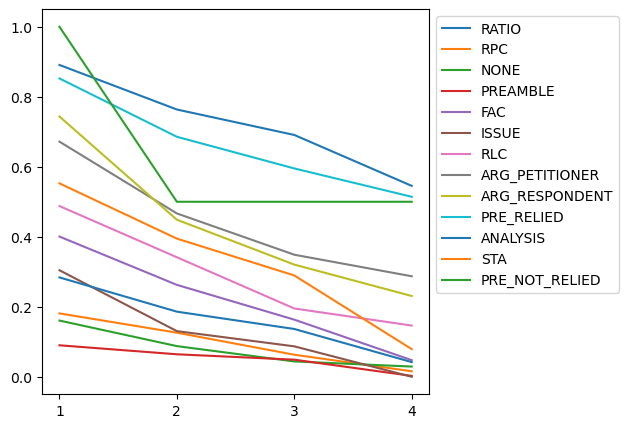

In [ ]:
def filter_rows(x, y, trueLabel):
    temp=df.loc[df['labels'] == trueLabel]
    count_per_row = temp[[f'labels_{model}' for model in models]].eq(y).sum(axis=1)
    filtered_rows = temp[count_per_row >= x]
    return filtered_rows

class_err_sim = [np.array([max(len(filter_rows(l, err_label, label).index) for err_label in df.labels.unique() if label != err_label) for l in range(1, len(models) + 1)]) / len(df[df.labels == label].index) for label in df.labels.unique()]

plt.figure(figsize=(5, 5))
for label, data in zip(df.labels.unique(), class_err_sim):
    fig = sns.lineplot(data, label=label)
    sns.move_legend(fig, 'upper left', bbox_to_anchor=(1, 1))
    fig.set_xticks(range(len(models)))
    fig.set_xticklabels(range(1, len(models) + 1))

In [ ]:
for label, data, data_sim in zip(df.labels.unique(), class_err, class_err_sim):
    print(f'{label} & {100*data[3]:.2f} & {100*data_sim[3]:.2f}')

RATIO & 67.27 & 54.55
RPC & 7.87 & 1.57
NONE & 8.76 & 2.92
PREAMBLE & 0.51 & 0.26
FAC & 11.87 & 4.75
ISSUE & 13.04 & 0.00
RLC & 39.02 & 14.63
ARG_PETITIONER & 57.44 & 28.72
ARG_RESPONDENT & 83.33 & 23.08
PRE_RELIED & 61.43 & 51.43
ANALYSIS & 5.70 & 4.19
STA & 23.68 & 7.89
PRE_NOT_RELIED & 100.00 & 50.00


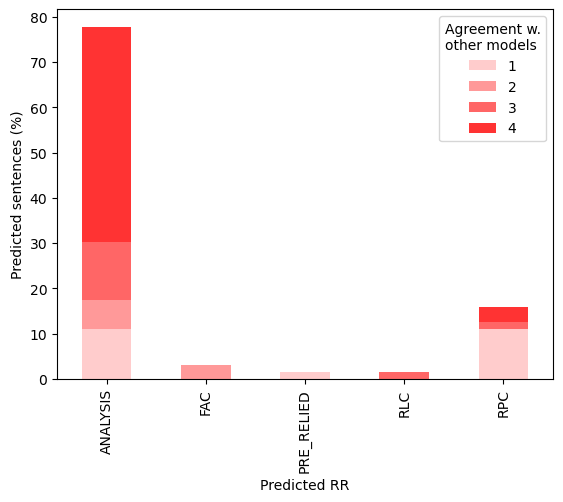

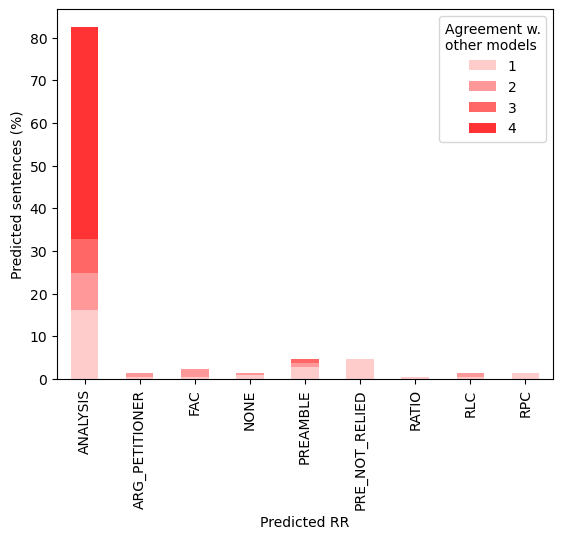

In [41]:
def count_labels(trueLabel):
    temp = df[df['labels'] == trueLabel]
    count_cols = ['annotation_id', *[f'labels_{model}' for model in models]]
    count_per_annotation = pd.melt(temp[count_cols], id_vars='annotation_id', var_name='prediction_column', value_name='label')
    count_per_annotation = pd.pivot_table(count_per_annotation, index='annotation_id', columns='label', aggfunc='size', fill_value=0).reset_index()
    return count_per_annotation

def reversed_count_labels(trueLabel):
    data = count_labels(trueLabel).drop(['annotation_id', trueLabel], axis=1)
    count_data = pd.DataFrame(index=data.columns, columns=data.stack().unique())
    for column in data.columns:
        count_data.loc[column] = data[column].value_counts()
    count_data = count_data.fillna(0).astype(np.int64).drop(0, axis=1)
    for i in count_data.columns:
        count_data[i] = count_data[i]
    return count_data.reindex(sorted(count_data.columns), axis=1)

def plot_reversed_count_labels(trueLabel):
    data = reversed_count_labels(trueLabel)
    data = data * 100 / data.sum().sum()
    fig = data.plot.bar(stacked=True, color=[(1, 1-.8*x/len(data.columns), 1-.8*x/len(data.columns)) for x in range(1, len(data.columns)+1)])
    fig.set_xlabel("Predicted RR")
    fig.set_ylabel("Predicted sentences (%)")
    fig.legend(title="Agreement w.\nother models")
    #fig.set_title(trueLabel)

plot_reversed_count_labels('RATIO')
plot_reversed_count_labels('PRE_RELIED')

In [ ]:
df_train = read_csv(f'{data_path}train.csv')
df_train

,doc_id,doc_index,sentence_index,annotation_id,text,meta_group,labels
0,1735,0,0,d7a902fe9c23417499a7ef782f9fbdeb,"IN THE HIGH COURT OF KARNATAKA,\n ...",Criminal,PREAMBLE
1,1735,0,1,8d41599e98424d9480c25109556a7d14,\n\n BEFORE\n\nTHE HON'BLE MR.JUSTICE ANA...,Criminal,PREAMBLE
2,1735,0,2,e501424117da40a7935c2d9f2fb2fe38,This Criminal Appeal is filed under Section 37...,Criminal,PREAMBLE
3,1735,0,3,4825806388fe43d39f73354b10b5b32d,\n\n This appeal coming on for hearing t...,Criminal,PREAMBLE
4,1735,0,4,d6893a25f82948f8be17fc9e876fb716,\n Heard the learned Counsel for the app...,Criminal,NONE
...,...,...,...,...,...,...,...
26082,4115,222,47,ed1047495bd141b787dc82f1c122171a,"As such, the High Court of Gujarath held that ...",Tax,ANALYSIS
26083,4115,222,48,79a753a82c5f4ea8a3c2ce0e241e15e9,"\n 10. The High Court of Madras, which was con...",Tax,ANALYSIS
26084,4115,222,49,803f5b29dc884254bfa84708ebb8cfb2,\n 11. The learned counsel for the appellant ...,Tax,ANALYSIS
26085,4115,222,50,04a8c49bbaff4061ae00f36d918650af,This Court concurs with the reasons assigned i...,Tax,RATIO


In [ ]:
df_a = df[(df.labels == 'ANALYSIS') & (df.labels_legalbert == 'ANALYSIS')]
df_ab = df[((df.labels == 'RATIO') | (df.labels == 'PRE_RELIED')) & (df.labels_legalbert == 'ANALYSIS')]
df_b = df[((df.labels == 'RATIO') & (df.labels_legalbert == 'RATIO')) | ((df.labels == 'PRE_RELIED') & (df.labels_legalbert == 'PRE_RELIED'))]
text_a = re.sub(r'[^ \w]+', '', ' '.join(df_a.text)).lower()
text_ab = re.sub(r'[^ \w]+', '', ' '.join(df_ab.text)).lower()
text_b = re.sub(r'[^ \w]+', '', ' '.join(df_b.text)).lower()
words_a = set(text_a.split())
words_ab = set(text_ab.split())
words_b = set(text_b.split())
words_a, words_b, words_ab = (
    words_a - words_b - words_ab,
    words_b - words_a - words_ab,
    words_ab - words_a - words_b
)

In [ ]:
df_train.groupby(df_train.labels).text.agg('\n'.join)

labels
ANALYSIS          \n 6. Given the rival contentions, as pointed ...
ARG_PETITIONER    \n 4. learned Counsel for the appellant would ...
ARG_RESPONDENT    It is claimed that the accused had looked afte...
FAC               2. The accused is in appeal in the following c...
ISSUE             The proposed substantial questions of law fram...
NONE              \n       Heard the learned Counsel for the app...
PREAMBLE                IN THE HIGH COURT OF KARNATAKA,\n       ...
PRE_NOT_RELIED    \nThe next decision is Gunda Subbayya v. Commi...
PRE_RELIED        \n The apex court, in the decision cited by th...
RATIO             In that view of the matter, it cannot be concl...
RLC               On conclusion of the trial and on examination ...
RPC               \n In the result, the appeal is allowed.\nThe ...
STA               Under s. 21 of the Act, the High Court exercis...
Name: text, dtype: object

In [ ]:
tokens = df_train.groupby(df_train.labels).text.agg('\n'.join).map(English().tokenizer)
tokens

labels
ANALYSIS          (\n , 6, ., Given, the, rival, contentions, ,,...
ARG_PETITIONER    (\n , 4, ., learned, Counsel, for, the, appell...
ARG_RESPONDENT    (It, is, claimed, that, the, accused, had, loo...
FAC               (2, ., The, accused, is, in, appeal, in, the, ...
ISSUE             (The, proposed, substantial, questions, of, la...
NONE              (\n       , Heard, the, learned, Counsel, for,...
PREAMBLE          (      , IN, THE, HIGH, COURT, OF, KARNATAKA, ...
PRE_NOT_RELIED    (\n, The, next, decision, is, Gunda, Subbayya,...
PRE_RELIED        (\n , The, apex, court, ,, in, the, decision, ...
RATIO             (In, that, view, of, the, matter, ,, it, can, ...
RLC               (On, conclusion, of, the, trial, and, on, exam...
RPC               (\n , In, the, result, ,, the, appeal, is, all...
STA               (Under, s., 21, of, the, Act, ,, the, High, Co...
Name: text, dtype: object

In [ ]:
token_sets = tokens.map(set)
token_sets

labels
ANALYSIS          {In, the, \n, favour, ., case, We, in, was, 1,...
ARG_PETITIONER    {., State, the, be, of, as, that, ., held, as,...
ARG_RESPONDENT    {302, Section, Government, purpose, was, some,...
FAC               {contractor, through, when, assault, Andhalgao...
ISSUE             {(, reached, cycle, 2, 1, as, -, \n\n , Inform...
NONE              {To, ,, of, for, :, 1986, of, Government, NAGE...
PREAMBLE          {., NO, -, MOHAMED, be, is, tahsildar, India, ...
PRE_NOT_RELIED    {Act, that, that, of, inter, Ogale, of, Papara...
PRE_RELIED        {(, The, \n, profits, \n, ., the, prosecuted, ...
RATIO             {assertion, costs, material, thought, was, we,...
RLC               {by, Assistant, allowed, it, relevant, M, pass...
RPC               {Appellant, \n, the, under, 06.07.2011, forthw...
STA               {,, such, referred, be, Section-, primary, whe...
Name: text, dtype: object

In [ ]:
len(words_a), len(words_b), len(words_ab)

(1809, 350, 428)

In [ ]:
from math import floor


[5*floor(len(w)/5) for w in words_a]

[0,
 5,
 5,
 0,
 10,
 0,
 10,
 10,
 10,
 5,
 5,
 5,
 5,
 5,
 0,
 0,
 0,
 5,
 5,
 5,
 0,
 5,
 10,
 10,
 0,
 10,
 0,
 10,
 5,
 5,
 0,
 0,
 0,
 0,
 10,
 5,
 0,
 5,
 5,
 10,
 5,
 5,
 0,
 5,
 5,
 5,
 5,
 5,
 5,
 10,
 0,
 10,
 0,
 5,
 5,
 5,
 5,
 10,
 5,
 5,
 10,
 5,
 10,
 0,
 10,
 5,
 0,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 0,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 0,
 10,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 10,
 0,
 5,
 5,
 5,
 10,
 5,
 5,
 5,
 5,
 5,
 0,
 5,
 10,
 0,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 0,
 5,
 5,
 5,
 0,
 5,
 5,
 5,
 10,
 10,
 5,
 5,
 5,
 10,
 5,
 5,
 5,
 5,
 0,
 5,
 5,
 10,
 0,
 0,
 0,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 0,
 5,
 10,
 5,
 10,
 5,
 5,
 5,
 0,
 5,
 5,
 5,
 0,
 5,
 5,
 10,
 0,
 5,
 0,
 5,
 5,
 5,
 0,
 5,
 10,
 5,
 0,
 0,
 10,
 5,
 5,
 5,
 5,
 10,
 0,
 10,
 5,
 5,
 15,
 0,
 5,
 0,
 5,
 5,
 5,
 5,
 5,
 5,
 10,
 5,
 10,
 5,
 5,
 5,
 5,
 5,
 10,
 5,
 5,
 5,
 5,
 10,
 5,
 0,
 5,
 5,
 0,
 5,
 5,
 5,
 0,
 5,
 0,
 5,
 10,
 0,
 5,
 5,
 0,
 5,
 10,
 5,
 5,
 5

In [ ]:
from typing import Any, Callable

def run_metric(metric: Callable[[str], Any]):
    axs = plt.subplots(1, 4, figsize=(16, 4))[1]
    results_a = [metric(w) for w in words_a]
    results_ab = [metric(w) for w in words_ab]
    results_b = [metric(w) for w in words_b]
    sns.violinplot({
        'a': results_a,
        'ab': results_ab,
        'b': results_b
    }, ax=axs[0])
    pd.Series(results_a).value_counts().sort_index().plot.bar(ax=axs[1])
    pd.Series(results_ab).value_counts().sort_index().plot.bar(ax=axs[2])
    pd.Series(results_b).value_counts().sort_index().plot.bar(ax=axs[3])

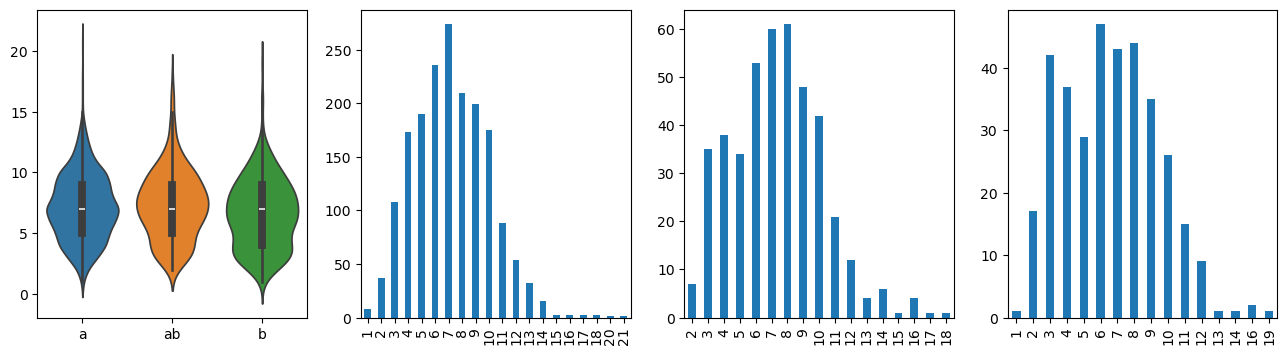

In [ ]:
run_metric(len)

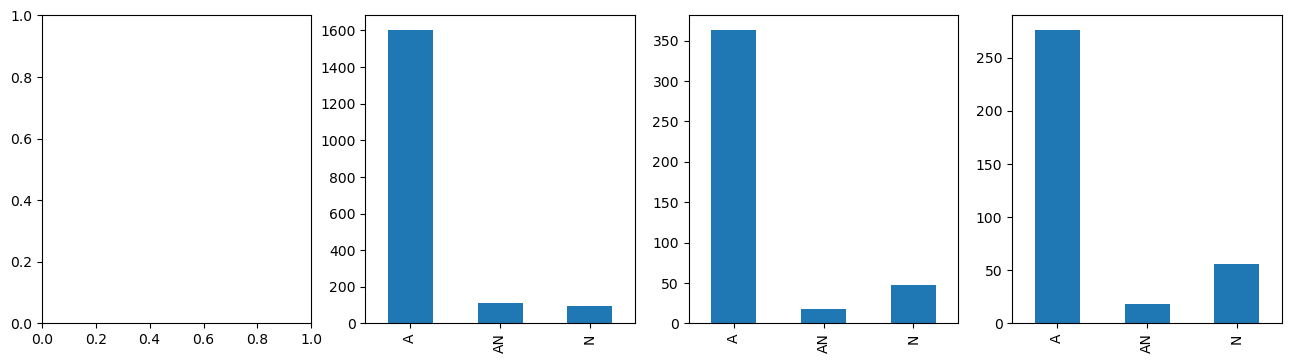

In [ ]:
run_metric(lambda w: "A" if w.isalpha() else "N" if w.isnumeric() else "AN")

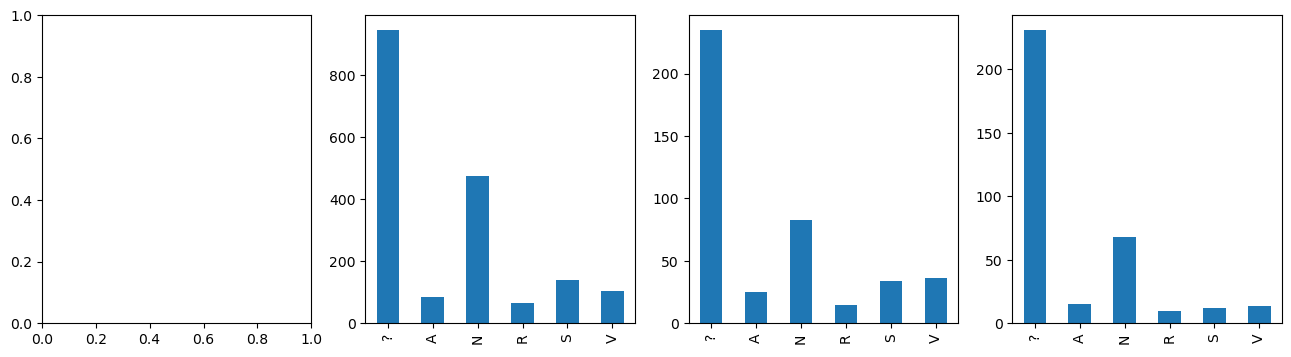

In [ ]:
def most_frequent_pos(w: str):
    l = [s.pos() for s in wn.synsets(w) if s.name().split('.')[0] == w]
    return Counter(l).most_common(1)[0][0].upper() if len(l) else '?'

run_metric(most_frequent_pos)

In [ ]:
k = 20
print("a", [w for w, _ in Counter(w for w in text_a.split() if w in words_a).most_common(k)])
print("ab", [w for w, _ in Counter(w for w in text_ab.split() if w in words_ab).most_common(k)])
print("b", [w for w, _ in Counter(w for w in text_b.split() if w in words_b).most_common(k)])

a ['incident', 'pw1', 'khan', 'complainant', 'injured', 'house', 'police', 'no2', 'hospital', 'know', 'knife', 'eye', 'pw', 'investigating', 'expansion', 'brother', 'she', 'period', 'lal', 'chand']
ab ['conflict', 'tribunal', '248', 'seervai', 'extended', 'add', 'purposes', '54', 'incidental', 'refund', 'clause', 'taxes', 'regarded', 'considerations', 'include', 'edn', 'interpreted', 'bring', '3372', 'orders']
b ['air', 'j', 'bench', 'approval', 'judgement', 'speaking', 'conveyance', 'inherent', 'synthetics', 'mp', 'examinations', '2014', 'quashed', 'matters', 'strictly', 'pc', 'satisfied', 'conclusions', '626', 'strict']
